# Baseline Training (No Distillation)
This notebook trains the **same student model WITHOUT knowledge distillation** to serve as a baseline for comparison.

### Training Setup:
```
Loss = α·CE(student, labels) + β·KL(student||teacher)
     = 1.0·CE + 0.0·KL
     = CE (standard supervised learning)
```

### Purpose:
- Train student model with **β = 0.0** (no teacher guidance)
- Use **identical hyperparameters** as notebook 06 (distillation training)
- Provide a **fair baseline** to measure the value of knowledge distillation

In [1]:
# Setup
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Imports
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import time

from src.data.data_loader import TeacherDataLoader
from src.data.preprocessor import ReasoningPreprocessor, PreprocessConfig
from src.data.dataset import ESNLIDataset, create_dataloaders

from src.models.student import StudentModel, StudentConfig
from src.models.teacher import FlanT5Teacher, TeacherConfig

from src.training.distillation import (
    DistillationConfig,
    TokenLevelDistillation,
)

from src.training.trainer import Trainer, TrainingConfig

In [2]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 1. Load Dataset

Use the **same dataset configuration** as notebook 06 for fair comparison.

In [ ]:
# Load dataset
print("=" * 70)
print("LOADING DATASET FOR BASELINE TRAINING")
print("=" * 70)

loader = TeacherDataLoader()
esnli_data = loader.load_esnli()

train_subset = esnli_data['train'].select(range(50000))
val_subset = esnli_data['validation'].select(range(5000))

print(f"\nTrain samples: {len(train_subset)}")
print(f"Val samples: {len(val_subset)}")

INFO:src.data.data_loader:Loading e-SNLI dataset from GitHub (OanaMariaCamburu/e-SNLI)...


LOADING DATASET FOR BASELINE TRAINING


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/259999 [00:00<?, ? examples/s]

Map:   0%|          | 0/289368 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/9842 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/9824 [00:00<?, ? examples/s]

INFO:src.data.data_loader:✓ Loaded e-SNLI: train=549367, val=9842, test=9824
INFO:src.data.data_loader:e-SNLI loaded successfully. Splits: ['train', 'validation', 'test']
INFO:src.data.data_loader:Sample counts: [('train', 549367), ('validation', 9842), ('test', 9824)]



✓ Train samples: 50000
✓ Val samples: 5000


In [ ]:
# Create datasets and dataloaders
preprocess_config = PreprocessConfig(
    model_name="google/flan-t5-small", # Using small model for faster processing
    max_source_length=128,
    max_target_length=64
)

preprocessor = ReasoningPreprocessor(preprocess_config)

# Create datasets
train_dataset = ESNLIDataset(train_subset, preprocessor, use_cache=True)
val_dataset = ESNLIDataset(val_subset, preprocessor, use_cache=True)

train_loader, val_loader = create_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=32,
    num_workers=4,
    pad_token_id=preprocessor.tokenizer.pad_token_id
)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

INFO:src.data.preprocessor:Loading tokenizer: google/flan-t5-small


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

INFO:src.data.dataset:Initialized ESNLIDataset with 50000 samples
INFO:src.data.dataset:Initialized ESNLIDataset with 5000 samples



Train batches: 1563
Val batches: 157


## 2. Load Teacher Model

We still need to load the teacher model for the distillation interface, but with **β = 0.0**, the KL loss will be multiplied by zero, effectively disabling teacher guidance.

In [ ]:
# Load Teacher Model
print("=" * 70)
print("LOADING TEACHER MODEL (for interface only, β=0.0)")
print("=" * 70)

teacher_config = TeacherConfig(
    model_name="google/flan-t5-xl",
    device=device,
    use_fp16=True if device == "cuda" else False,
    max_source_length=128,
    max_target_length=64
)

print(f"Loading {teacher_config.model_name}...")
teacher = FlanT5Teacher(teacher_config)

print(f"\nTeacher loaded (will NOT be used for training, β=0.0)")
print(f"  Parameters: {teacher.count_parameters():,}")

INFO:src.models.teacher:Initializing teacher model: google/flan-t5-xl
`torch_dtype` is deprecated! Use `dtype` instead!


LOADING TEACHER MODEL (for interface only, β=0.0)
Loading google/flan-t5-xl...


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

INFO:src.models.teacher:Teacher model loaded on cuda with dtype torch.float16
INFO:src.models.teacher:Teacher parameters: 2,849,757,184 (frozen)



✓ Teacher loaded (will NOT be used for training, β=0.0)
  Parameters: 2,849,757,184


## 3. Initialize Student Model

In [ ]:
# Initialize Student Model - SAME config as notebook 06
print("=" * 70)
print("INITIALIZING STUDENT MODEL")
print("=" * 70)

student_config = StudentConfig(
    model_name="google/flan-t5-small",
    max_source_length=128,
    max_target_length=64,
    device=device
)

student = StudentModel(student_config)

print(f"\nStudent loaded!")
print(f"  Parameters: {student.count_parameters():,}")
print(f"  Memory: {student.get_memory_footprint()['total_mb']:.2f} MB")

INFO:src.models.student:Initializing student model: google/flan-t5-small


INITIALIZING STUDENT MODEL


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
INFO:src.models.student:Model loaded successfully on cuda
INFO:src.models.student:Model parameters: 76,961,152



✓ Student loaded!
  Parameters: 76,961,152
  Memory: 293.58 MB


## 4. Configure Baseline Training (β = 0.0)

**KEY DIFFERENCE**: `distill_weight = 0.0` means NO knowledge distillation.

```
Loss = 1.0·CE + 0.0·KL = CE (standard supervised learning)
```

In [ ]:
# Configure Baseline Training (NO DISTILLATION)
print("=" * 70)
print("CONFIGURING BASELINE TRAINING (β = 0.0)")
print("=" * 70)

# BASELINE configuration: β = 0.0 (NO teacher guidance)
baseline_distill_config = DistillationConfig(
    ce_weight=1.0,        # α - Cross-entropy weight
    distill_weight=0.0,   # β = 0.0 → NO KL divergence loss!
    temperature=2.0,      # Not used when β=0.0
    label_smoothing=0.0,
    distillation_type="token_level"
)

# Create distillation strategy (KL will be multiplied by 0)
baseline_strategy = TokenLevelDistillation(
    teacher_model=teacher,
    config=baseline_distill_config
)

print(f"\nBaseline Training configured!")
print(f"  Loss = {baseline_distill_config.ce_weight}·CE + {baseline_distill_config.distill_weight}·KL")
print(f"  Loss = CE only (standard supervised learning)")

INFO:src.training.distillation:Initialized DistillationLoss with config:
INFO:src.training.distillation:  CE weight: 1.0
INFO:src.training.distillation:  Distill weight: 0.0
INFO:src.training.distillation:  Temperature: 2.0
INFO:src.training.distillation:  Type: token_level
INFO:src.training.distillation:Initialized TokenLevelDistillation with teacher model
INFO:src.training.distillation:  α (CE weight): 1.0
INFO:src.training.distillation:  β (Distill weight): 0.0
INFO:src.training.distillation:  Temperature: 2.0


CONFIGURING BASELINE TRAINING (β = 0.0)

✓ Baseline Training configured!
  Loss = 1.0·CE + 0.0·KL
  Loss = CE only (standard supervised learning)
  Teacher guidance: DISABLED (β=0.0)


## 5. Initialize Trainer

Use **IDENTICAL training hyperparameters** as notebook 06 for fair comparison.

In [ ]:
# Create training configuration - SAME as notebook 06
print("=" * 70)
print("INITIALIZING TRAINER (SAME config as distillation training)")
print("=" * 70)

training_config = TrainingConfig(
    num_epochs=7,                          # SAME
    learning_rate=5e-5,                    # SAME
    warmup_steps=1200,                     # SAME
    eval_steps=1000,                       # SAME
    save_steps=1000,                       # SAME
    logging_steps=50,                      # SAME
    output_dir="../experiments/baseline",  
    eval_strategy="steps",                 # SAME
    save_strategy="steps",                 # SAME
    save_total_limit=3,                    # SAME
    early_stopping_patience=5,             # SAME
    early_stopping_threshold=0.001,        # SAME
    lr_scheduler_type="cosine",            # SAME
    gradient_accumulation_steps=2,         # SAME
    max_grad_norm=1.0,                     # SAME
    fp16=False,                            # SAME
    seed=42                                # SAME seed for reproducibility
)

# Create trainer with baseline strategy
trainer = Trainer(
    model=student,
    train_dataloader=train_loader,
    eval_dataloader=val_loader,
    distillation_strategy=baseline_strategy,
    config=training_config
)

print("\nTrainer initialized!")
print(f"  Total training steps: {len(train_loader) * training_config.num_epochs}")
print(f"  Training type: BASELINE (no distillation)")
print(f"  Loss: CE only (β=0.0)")
print(f"  Output: {training_config.output_dir}")

INFO:src.training.trainer:Training config saved to ../experiments/baseline/training_config.json
INFO:src.training.trainer:Trainer initialized
INFO:src.training.trainer:Output directory: ../experiments/baseline
INFO:src.training.trainer:Total training steps: 10941


INITIALIZING TRAINER (SAME config as distillation training)

✓ Trainer initialized!
  Total training steps: 10941
  Training type: BASELINE (no distillation)
  Loss: CE only (β=0.0)
  Output: ../experiments/baseline


## 6. Run Baseline Training

In [ ]:
# Train Baseline Model
print("\n" + "=" * 70)
print("STARTING BASELINE TRAINING (NO DISTILLATION)")
print("=" * 70)
print(f"\nStudent: {student_config.model_name}")
print(f"Loss: {baseline_distill_config.ce_weight}·CE + {baseline_distill_config.distill_weight}·KL")
print(f"Loss: CE only (standard supervised learning)")
print(f"Teacher guidance: DISABLED")
print("=" * 70)

# Start training
start_time = time.time()

# Train the model
history = trainer.train()

# Measure training time
training_time = time.time() - start_time

print(f"\nBaseline training completed in {training_time/60:.1f} minutes")
print(f"Average time per epoch: {training_time / training_config.num_epochs:.1f}s")

INFO:src.training.trainer:======================================================================
INFO:src.training.trainer:STARTING TRAINING
INFO:src.training.trainer:======================================================================
INFO:src.training.trainer:Epochs: 7
INFO:src.training.trainer:Train batches per epoch: 1563
INFO:src.training.trainer:Eval batches: 157
INFO:src.training.trainer:
INFO:src.training.trainer:Epoch 1/7
INFO:src.training.trainer:======================================================================



STARTING BASELINE TRAINING (NO DISTILLATION)

Student: google/flan-t5-small
Loss: 1.0·CE + 0.0·KL
Loss: CE only (standard supervised learning)
Teacher guidance: DISABLED


Epoch 1:   0%|          | 0/1563 [00:02<?, ?it/s, loss=3.6748, lr=5.00e-06]INFO:src.training.trainer:Step 0 | ce_loss: 3.6748 | total_loss: 3.6748 | LR: 5.00e-06
INFO:src.training.trainer:
Running evaluation...

Evaluating: 100%|██████████| 157/157 [00:08<00:00, 18.25it/s]
INFO:src.training.trainer:
Evaluation at step 0:
INFO:src.training.trainer:  eval_loss: 3.6817
INFO:src.training.trainer:Saving checkpoint to ../experiments/baseline/best_model
INFO:src.models.student:Saving model to ../experiments/baseline/best_model
INFO:src.models.student:Model saved successfully
INFO:src.training.trainer:Saving checkpoint to ../experiments/baseline/checkpoint-0
INFO:src.models.student:Saving model to ../experiments/baseline/checkpoint-0
INFO:src.models.student:Model saved successfully
Epoch 1: 100%|██████████| 1563/1563 [22:35<00:00,  1.15it/s, loss=1.3149, lr=3.43e-05]
INFO:src.training.trainer:
Epoch 1 metrics:
INFO:src.training.trainer:  loss: 1.6901
INFO:src.training.trainer:  ce_loss: 1.6901


✓ Baseline training completed in 159.1 minutes
✓ Average time per epoch: 1363.5s


## 7. Analyze Training History

In [10]:
# Display training history
print("=" * 70)
print("BASELINE TRAINING HISTORY")
print("=" * 70)

train_history = history['train_history']
eval_history = history['eval_history']

print(f"\nTrain history ({len(train_history)} epochs):")
for i, metrics in enumerate(train_history):
    print(f"  Epoch {i+1}: loss={metrics['loss']:.4f}")

print(f"\nEval history ({len(eval_history)} evaluations):")
for i, metrics in enumerate(eval_history[:5]):
    print(f"  Eval {i+1}: eval_loss={metrics['eval_loss']:.4f}")
if len(eval_history) > 5:
    print(f"  ... and {len(eval_history) - 5} more")

BASELINE TRAINING HISTORY

Train history (7 epochs):
  Epoch 1: loss=1.6901
  Epoch 2: loss=1.3688
  Epoch 3: loss=1.3041
  Epoch 4: loss=1.2646
  Epoch 5: loss=1.2357
  Epoch 6: loss=1.2154
  Epoch 7: loss=1.1991

Eval history (12 evaluations):
  Eval 1: eval_loss=3.6817
  Eval 2: eval_loss=1.2309
  Eval 3: eval_loss=1.2309
  Eval 4: eval_loss=1.1852
  Eval 5: eval_loss=1.1852
  ... and 7 more


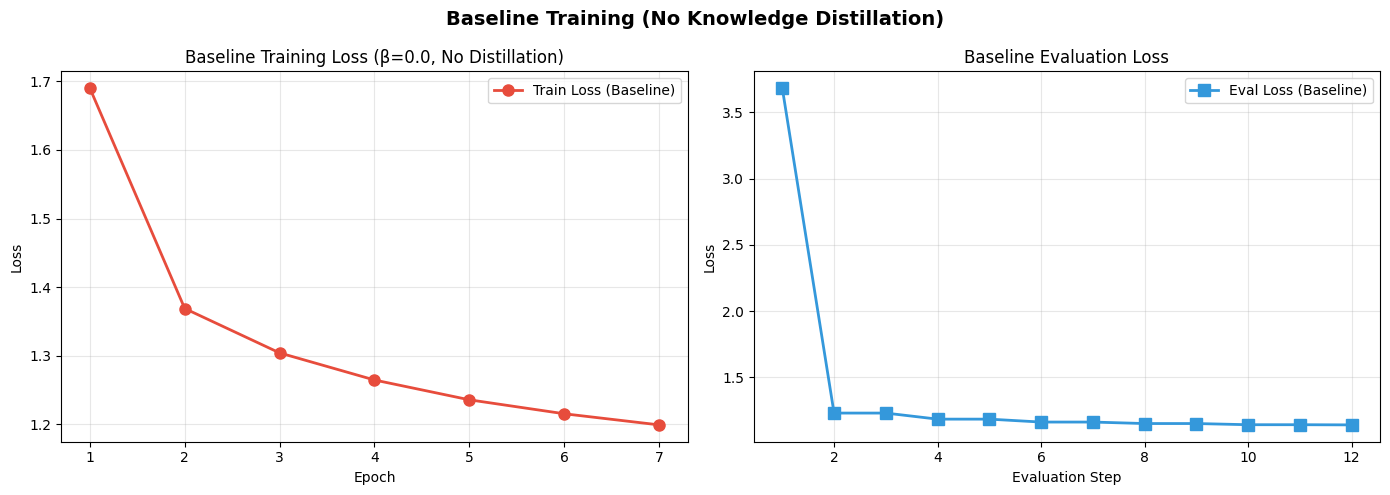


Loss reduction: 29.05%
Initial loss: 1.6901
Final loss: 1.1991


In [11]:
# Visualize training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training loss per epoch
epochs = range(1, len(train_history) + 1)
train_losses = [m['loss'] for m in train_history]

axes[0].plot(epochs, train_losses, marker='o', linewidth=2, markersize=8, 
             color='#e74c3c', label='Train Loss (Baseline)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Baseline Training Loss (β=0.0, No Distillation)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Evaluation loss over time
if eval_history:
    eval_steps = range(1, len(eval_history) + 1)
    eval_losses = [m['eval_loss'] for m in eval_history]
    
    axes[1].plot(eval_steps, eval_losses, marker='s', linewidth=2, markersize=8,
                 color='#3498db', label='Eval Loss (Baseline)')
    axes[1].set_xlabel('Evaluation Step')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Baseline Evaluation Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.suptitle('Baseline Training (No Knowledge Distillation)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print loss reduction
if len(train_losses) > 1:
    initial_loss = train_losses[0]
    final_loss = train_losses[-1]
    reduction = (initial_loss - final_loss) / initial_loss * 100
    print(f"\nLoss reduction: {reduction:.2f}%")
    print(f"Initial loss: {initial_loss:.4f}")
    print(f"Final loss: {final_loss:.4f}")

## 8. Test Generation

In [12]:
# Test generation after baseline training
print("=" * 70)
print("TESTING GENERATION (BASELINE MODEL)")
print("=" * 70)

student.model.eval()

# Get a batch from validation set
val_batch = next(iter(val_loader))
val_batch = {k: v.to(device) for k, v in val_batch.items()}

# Generate predictions
with torch.no_grad():
    generated_ids = student.generate(
        input_ids=val_batch['input_ids'][:3],
        attention_mask=val_batch['attention_mask'][:3],
        max_length=64,
        num_beams=4
    )

# Decode
predictions = student.decode_batch(generated_ids)
inputs = student.decode_batch(val_batch['input_ids'][:3])

labels = val_batch['labels'][:3].clone()
labels[labels == -100] = student.tokenizer.pad_token_id
ground_truths = student.decode_batch(labels)

# Display
for i in range(3):
    print(f"\n{'='*70}")
    print(f"SAMPLE {i+1}")
    print(f"{'='*70}")
    print(f"\nInput:\n{inputs[i]}")
    print(f"\nGround Truth:\n{ground_truths[i]}")
    print(f"\nBaseline Prediction:\n{predictions[i]}")

TESTING GENERATION (BASELINE MODEL)

SAMPLE 1

Input:
nli premise: Two women are embracing while holding to go packages. hypothesis: The sisters are hugging goodbye while holding to go packages after just eating lunch.

Ground Truth:
neutral explanation: The to go packages may not be from lunch.

Baseline Prediction:
neutral explanation: Just because two women are embracing while holding to go packages does not mean they are sisters hugging goodbye.

SAMPLE 2

Input:
nli premise: Two women are embracing while holding to go packages. hypothesis: Two woman are holding packages.

Ground Truth:
entailment explanation: Saying the two women are holding packages is a way to paraphrase that the packages they are holding are to go packages.

Baseline Prediction:
entailment explanation: Holding to go packages is a rephrasing of holding packages.

SAMPLE 3

Input:
nli premise: Two women are embracing while holding to go packages. hypothesis: The men are fighting outside a deli.

Ground Truth:
con

## 9. Save Baseline Model

In [ ]:
# Check saved checkpoints
print("=" * 70)
print("SAVED BASELINE CHECKPOINTS")
print("=" * 70)

output_dir = Path(training_config.output_dir)

if output_dir.exists():
    checkpoints = list(output_dir.iterdir())
    print(f"\nFound {len(checkpoints)} items in output directory:")
    for checkpoint in sorted(checkpoints):
        if checkpoint.is_dir():
            size = sum(f.stat().st_size for f in checkpoint.rglob('*') if f.is_file())
            print(f"- {checkpoint.name} ({size / 1e6:.2f} MB)")
        else:
            print(f"- {checkpoint.name}")
else:
    print("\nOutput directory not found!")

SAVED BASELINE CHECKPOINTS

Found 6 items in output directory:
- best_model (926.17 MB)
- checkpoint-3000 (926.17 MB)
- checkpoint-4000 (926.17 MB)
- checkpoint-5000 (926.17 MB)
- final_model (926.17 MB)
- training_config.json
